# Environment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MultiAgentGridEnvironment:
    def __init__(self, grid_size=10, agent_positions=None, random_seed=42, obstacle_count=10):
        """
        Initializes the grid environment.
        :param grid_size: Size of the grid (grid_size x grid_size).
        :param agent_positions: Initial positions of the agents as a list of tuples.
        :param random_seed: Seed for random obstacle generation.
        :param obstacle_count: Number of obstacles to generate.
        """
        self.grid_size = grid_size
        self.grid = np.zeros((grid_size, grid_size), dtype=int)  # 0 for unvisited, 1 for visited
        self.agent_positions = agent_positions if agent_positions is not None else [(0, 0), (9, 0), (9, 9)]
        self.num_agents = len(self.agent_positions)
        self.random_seed = random_seed
        self.obstacle_count = obstacle_count

        # Generate obstacles with fixed randomness
        self.obstacles = self._generate_obstacles(self.obstacle_count)

        # Initialize visited cells and set obstacles
        for obstacle in self.obstacles:
            self.grid[obstacle] = -1  # -1 for obstacles

        # Initialize agent positions
        for pos in self.agent_positions:
            self.grid[pos] = 1  # Agents' starting positions are marked as visited

        self.done = False
        self.steps = 0

    def _generate_obstacles(self, count):
        """Generate random sparse obstacles avoiding agent positions."""
        np.random.seed(self.random_seed)  # Set the random seed for reproducibility
        obstacles = set()
        while len(obstacles) < count:
            pos = (np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size))
            if pos not in self.agent_positions:  # Avoid placing obstacles on agent positions
                obstacles.add(pos)
        return list(obstacles)

    def reset(self):
        """Resets the environment for a new episode."""
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        for obstacle in self.obstacles:
            self.grid[obstacle] = -1
        for pos in self.agent_positions:
            self.grid[pos] = 1
        self.steps = 0
        self.done = False
        return self.grid, self.agent_positions

    def step(self, actions):
      """
      Executes the given actions for all agents.

      :param actions: A list of actions for all agents. Actions are:
                      0: up, 1: down, 2: left, 3: right
      :return: next_state, rewards, done
      """
      rewards = np.zeros(self.num_agents)
      next_positions = []

      # Define movement deltas for actions
      moves = {
          0: (-1, 0),  # Up
          1: (1, 0),   # Down
          2: (0, -1),  # Left
          3: (0, 1)    # Right
      }

      # Process each agent's action
      for i, action in enumerate(actions):
          current_pos = self.agent_positions[i]
          if current_pos is None:  # Agent is out of play
              next_positions.append(None)
              rewards[i] = 0
              continue

          # Calculate the next position
          move = moves[action]
          next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

          # Check bounds
          if not (0 <= next_pos[0] < self.grid_size and 0 <= next_pos[1] < self.grid_size):
              rewards[i] = -1  # Penalize out-of-bound moves
              next_positions.append(current_pos)  # Stay in place
              continue

          # Check obstacles
          if self.grid[next_pos] == -1:
              next_positions.append(current_pos)  # Stay in place
              continue  # No penalty for hitting obstacles

          # Check revisiting
          if self.grid[next_pos] == 1:
              rewards[i] = -1  # Penalize revisiting
          else:
              rewards[i] = 1  # Reward for covering a new cell

          # If the agent stays in the same position, penalize it
          if next_pos == current_pos:
              rewards[i] = -0.5  # Penalize for not moving

          # Update position
          next_positions.append(next_pos)
          self.grid[next_pos] = 1

      # Update agent positions
      self.agent_positions = next_positions

      # Check if all cells are covered
      if np.all(self.grid != 0):
          self.done = True
          rewards += 50  # Bonus reward for complete coverage

      self.steps += 1
      return self.grid, rewards, self.done

    def render(self):
        """Renders the current state of the grid with a black-and-white grid and colored agents."""
        display_grid = np.zeros((self.grid_size, self.grid_size, 3), dtype=float)  # RGB grid for plotting

        # Set white (1,1,1) for empty cells
        display_grid[self.grid == 0] = [1, 1, 1]
        # Set black (0,0,0) for obstacles
        display_grid[self.grid == -1] = [0, 0, 0]
        # Set visited cells as light gray
        display_grid[self.grid == 1] = [0.8, 0.8, 0.8]

        # Add agent colors
        agent_colors = [
            [1, 0, 0],  # Red for Agent 1
            [0, 0, 1],  # Blue for Agent 2
            [0, 1, 0],  # Green for Agent 3
        ]
        for i, pos in enumerate(self.agent_positions):
            if pos is not None:
                display_grid[pos] = agent_colors[i % len(agent_colors)]

        # Plot the grid
        plt.figure(figsize=(8, 8))
        plt.imshow(display_grid, origin="upper")
        plt.title("Multi-Agent Grid Environment")
        plt.axis('off')  # Turn off axes
        plt.show()


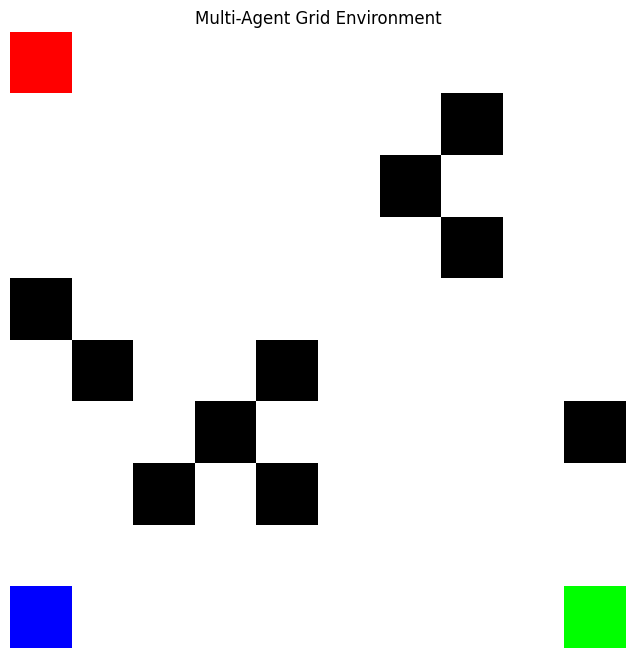

In [ ]:
if __name__ == "__main__":
    # Initialize the environment with default settings
    env = MultiAgentGridEnvironment()

    # Render the initial state of the grid
    env.render()
